In [ ]:
#Pre-meeting analysis

#The following code removes silences from the clips of speakers and splits it into recordings of 1 second each
#These recordings will be used to train the Voice Classification Model

#Path - 'C:\\Users\\Rohan'
#Speaker Audios will be stored in folder - 'Recordings'
#Audio clips with silences removed will be stored in folder - 'Recordings without silences'
#Splitted audio clips of each 1 second will be stored in folder - 'Speech data'

In [1]:
import os
from pydub import AudioSegment
from pydub.silence import split_on_silence
import soundfile as sf

C:\Users\Rohan\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
#Emptying the 'Recordings without silences' folder
folder_name = "Recordings without silences"
filenames = os.listdir(folder_name)
for f in filenames:
    os.remove(folder_name + "//" + f)

#To remove silences from wav files
SPEAKERS = []
os.chdir("C:\\Users\\Rohan")
input_folder = "Recordings"
output_folder = "Recordings without silences"
filelist = os.listdir(input_folder)

for x, file in enumerate(filelist):
    SPEAKERS.append(file.split('.')[0])
    sound_file = AudioSegment.from_wav(input_folder + "\\" + file)
    audio_chunks = split_on_silence(sound_file, min_silence_len=500, silence_thresh=-40)

    count = 0
    for i, chunk in enumerate(audio_chunks):
        out_file = "{0}-{1}-{2}.wav".format(x, file.split('.')[0], i)
        #print("exporting", out_file)
        chunk.export(output_folder + "\\" + out_file, format="wav")
        
        data, fs = sf.read(output_folder + "\\" + out_file)
        sf.write(output_folder + "\\" + out_file.split('.')[0] + ".flac", data, fs)
        os.remove(output_folder + "\\" + out_file)
        count += 1

    print(count, "files exported")

41 files exported
46 files exported
99 files exported
68 files exported


In [3]:
#Emptying the 'Speech Data' folder
folder_name = "Speech data"
filenames = os.listdir(folder_name)
for f in filenames:
    os.remove(folder_name + "//" + f)

#Splitting the recordings into multiple recordings each of 1 second
folder_name = 'Recordings without silences'
output_folder_name = 'Speech data'
filelist = os.listdir(folder_name)
speaker = filelist[0].split('-')[0]
count = 0
continue_flag = 0

for filename in filelist:
    if continue_flag == 1:
        if filename.split('-')[0] == speaker:
            continue
        else:
            continue_flag = 0
            count = 0
            speaker = filename.split('-')[0]
    
    filename = filename.split(".")[0]
    
    data, fs = sf.read(folder_name + "\\" + filename + ".flac") 
    sf.write("temp.wav", data, fs)  
    
    clip = AudioSegment.from_wav("temp.wav")
    file_name = filename + "_part"
    i = 1
    t1 = 0
    names = []
    while t1+1000 <= len(clip):
        part = clip[t1:t1+1000]
        name = file_name + str(i)
        part.export(name + ".wav", format="wav")
        i += 1
        t1 += 1000
        names.append(name)   

    for f in names:
        if count < 120:
            data, fs = sf.read(f + ".wav")
            sf.write(output_folder_name + "//" + f + ".flac", data, fs)
            
        os.remove(f + ".wav")
        count += 1    
        if count == 120:
            continue_flag = 1

    os.remove("temp.wav")

print("Done")

Done


In [ ]:
#Pre-meeting analysis

#The following code will create the Voice Classification Model based on the processed audio clips

In [4]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

C:\Users\Rohan\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
#creating a Pandas dataframe to store the audio clips
filelist = os.listdir('Speech data')
df = pd.DataFrame(filelist)
df.columns = ['file']

In [6]:
#function that will extract the features from audio clips
#these features will make the dataset
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('Speech data')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    return mfccs, chroma, mel, contrast, tonnetz

In [7]:
#Extracting the features from the clips in dataframe and saving it for future use

startTime = datetime.now()
features_label = df.apply(extract_features, axis=1)
print(datetime.now() - startTime)
np.save('Speech features\\features_label', features_label)

C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=690
  n_fft, y.shape[-1]
C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=345
  n_fft, y.shape[-1]


0:01:48.744673


In [8]:
#Converting the features into a list object
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

#Getting the labels for each feature
speaker = []
for i in range(0, len(df)):
    speaker.append(df['file'][i].split('-')[0])
df['speaker'] = speaker
labels = speaker

TOTAL_SPEAKERS = df['speaker'].nunique()

In [9]:
#(OPTIONAL)
#Splitting dataframe into train, validation and test as 70%, 20% and 10% respectively
#This needs to be done if we wish to run a test with the testing part
xtrain = pd.DataFrame(columns = ['file', 'speaker'])
ytrain = pd.DataFrame(columns = ['file', 'speaker'])
xval = pd.DataFrame(columns = ['file', 'speaker'])
yval = pd.DataFrame(columns = ['file', 'speaker'])
xtest = pd.DataFrame(columns = ['file', 'speaker'])
ytest = pd.DataFrame(columns = ['file', 'speaker'])

count = 1
total = 0
sp = df['speaker'][0]
for i in range(1, len(df)):
    if df['speaker'][i] == sp:
        count += 1
    else:
        train = int(0.7 * count)
        val = int(0.2 * count)
        test = count - val - train
        xtrain = pd.concat([xtrain, df[total:total+train]])
        xval = pd.concat([xval, df[total+train:total+train+val]])
        xtest = pd.concat([xtest, df[total+train+val:total+count]])
        sp = df['speaker'][i]
        total += count
        count = 1
train = int(0.7 * count)
val = int(0.2 * count)
test = count - val - train
xtrain = pd.concat([xtrain, df[total:total+train]])
xval = pd.concat([xval, df[total+train:total+train+val]])
xtest = pd.concat([xtest, df[total+train+val:total+count]])

In [10]:
#Creating features and labels
X = np.array(features)
y = np.array(labels)

lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [11]:
#Creating the dataset and splitting in into training, validation and testing data as 70%, 20% and 10% respectively 
X_train = np.zeros([1, 193])
y_train = np.zeros([1, 4])
X_val = np.zeros([1, 193])
y_val = np.zeros([1, 4])
X_test = np.zeros([1, 193])
y_test = np.zeros([1, 4])

count = 1
total = 0
sp = df['speaker'][0]
for i in range(1, len(df)):
    if df['speaker'][i] == sp:
        count += 1
    else:
        train = int(0.7 * count)
        val = int(0.2 * count)
        test = count - val - train
        
        X_train = np.concatenate((X_train, X[total:total+train]))
        y_train = np.concatenate((y_train, y[total:total+train]))
        X_val = np.concatenate((X_val, X[total+train:total+train+val]))
        y_val = np.concatenate((y_val, y[total+train:total+train+val]))
        X_test = np.concatenate((X_test, X[total+train+val:total+count]))
        y_test = np.concatenate((y_test, y[total+train+val:total+count]))
        
        sp = df['speaker'][i]
        total += count
        count = 1
train = int(0.7 * count)
val = int(0.2 * count)
test = count - val - train
X_train = np.concatenate((X_train, X[total:total+train]))
y_train = np.concatenate((y_train, y[total:total+train]))
X_val = np.concatenate((X_val, X[total+train:total+train+val]))
y_val = np.concatenate((y_val, y[total+train:total+train+val]))
X_test = np.concatenate((X_test, X[total+train+val:total+count]))
y_test = np.concatenate((y_test, y[total+train+val:total+count]))

X_train = np.delete(X_train, 0, 0)
y_train = np.delete(y_train, 0, 0)
X_val = np.delete(X_val, 0, 0)
y_val = np.delete(y_val, 0, 0)
X_test = np.delete(X_test, 0, 0)
y_test = np.delete(y_test, 0, 0)

In [12]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [13]:
#Creating the model and adding layers to it
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(TOTAL_SPEAKERS, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [14]:
#Training the model and saving it
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
model.save("C:\\Users\\Rohan\\model\\speaker_classification_model.h5")

Epoch 1/10
11/11 [==============================] - 0s 17ms/step - loss: 1.2439 - accuracy: 0.4256 - val_loss: 0.5851 - val_accuracy: 0.9896
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.4951 - accuracy: 0.9018 - val_loss: 0.1557 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9762 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9881 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0277 - accuracy: 0.9970 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 0.9970 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0133 - accuracy: 0.9970 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 8/10
11/11 [=

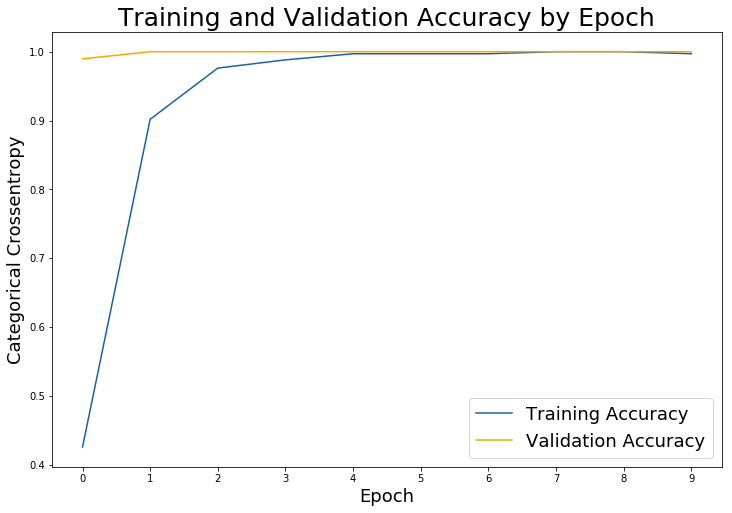

In [16]:
#(OPTIONAL)
#Generating the accuracy graph
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,10,1), range(0,10,1))

plt.legend(fontsize = 18);

In [17]:
#(OPTIONAL)
#Testing the model
preds = model.predict_classes(X_test)
preds = lb.inverse_transform(preds)
xtest['preds'] = preds
xtest

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


C:\Users\Rohan\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,file,speaker,preds
108,0-Puru-37_part3.flac,0,0
109,0-Puru-37_part4.flac,0,0
110,0-Puru-37_part5.flac,0,0
111,0-Puru-38_part1.flac,0,0
112,0-Puru-38_part2.flac,0,0
113,0-Puru-38_part3.flac,0,0
114,0-Puru-38_part4.flac,0,0
115,0-Puru-38_part5.flac,0,0
116,0-Puru-3_part1.flac,0,0
117,0-Puru-3_part2.flac,0,0


In [ ]:
#Post-meeting analysis

#The following code will process the meeting recording clip and use the model to recognize the speakers

#Path - 'C:\\Users\\Rohan'
#Meeting Recording clip will be stored in folder - 'Meeting Recording'
#Silence removed meeting recording clips will be stored in folder - 'Meeting Recording without silences'

In [18]:
#Emptying the 'Meeting Recording without silences' folder
folder_name = "Meeting Recording without silences"
filenames = os.listdir(folder_name)
for f in filenames:
    os.remove(folder_name + "//" + f)

#To remove silences from wav files
startTime = datetime.now()

os.chdir("C:\\Users\\Rohan")
input_folder = "Meeting Recording"
output_folder = "Meeting Recording without silences"
filelist = os.listdir(input_folder)

for file in filelist:
    sound_file = AudioSegment.from_wav(input_folder + "\\" + file)
    audio_chunks = split_on_silence(sound_file, min_silence_len=500, silence_thresh=-40)

    count = 0
    for i, chunk in enumerate(audio_chunks):
        out_file = "{0}-{1}.wav".format(file.split('.')[0], i)
        #print("exporting", out_file)
        chunk.export(output_folder + "\\" + out_file, format="wav")
        
        data, fs = sf.read(output_folder + "\\" + out_file)
        sf.write(output_folder + "\\" + out_file.split('.')[0] + ".flac", data, fs)
        os.remove(output_folder + "\\" + out_file)
        count += 1

    print(count, "files exported")

print(datetime.now() - startTime)

62 files exported
0:00:14.583883


In [19]:
#function that will extract the features from meeting audio clips
def extract_features_meeting(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('Meeting Recording without silences')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

In [20]:
#extracting features from the meeting clips
filelist = os.listdir("Meeting Recording without silences")
df2 = pd.DataFrame(filelist)
df2.columns = ['file']

startTime = datetime.now()

features_label = df2.apply(extract_features_meeting, axis=1)

print(datetime.now() - startTime)
np.save('Speech features\\features_label_meeting', features_label)

C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=586
  n_fft, y.shape[-1]
C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=293
  n_fft, y.shape[-1]
C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1013
  n_fft, y.shape[-1]
C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=769
  n_fft, y.shape[-1]
C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=385
  n_fft, y.shape[-1]
C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarn

0:00:26.923996


C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=992
  n_fft, y.shape[-1]
C:\Users\Rohan\AppData\Roaming\Python\Python36\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=496
  n_fft, y.shape[-1]


In [21]:
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

test = np.array(features)
test = ss.fit_transform(test)

labels = [str(i) for i in range(len(SPEAKERS))]
temp = np.array(labels)
temp = lb.fit_transform(temp)

preds2 = model.predict_classes(test)
preds2 = lb.inverse_transform(preds2)

names = [SPEAKERS[int(p)] for p in preds2]
df2['preds'] = preds2
df2['names'] = names
pd.set_option('display.max_rows', 500)
df2

C:\Users\Rohan\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,file,preds,names
0,Meeting02-0.flac,1,Rohan
1,Meeting02-1.flac,1,Rohan
2,Meeting02-10.flac,3,Yash
3,Meeting02-11.flac,3,Yash
4,Meeting02-12.flac,3,Yash
5,Meeting02-13.flac,2,Siddharth
6,Meeting02-14.flac,0,Puru
7,Meeting02-15.flac,0,Puru
8,Meeting02-16.flac,0,Puru
9,Meeting02-17.flac,1,Rohan


In [ ]:
#Post-meeting analysis

#The following code will implement Speech-To-Text conversion for all the audio clips
#It will also generate the personalized transcript

In [22]:
import logging
import boto3
from botocore.exceptions import ClientError
import time
import urllib
import json
from boto3 import client
import random

In [23]:
#Deleting files from S3 bucket

#Speech-to-text Conversion - Amazon API
with open('F:\\Under Construction\\Voice-To-Text Note Making\\Speech-To-Text\\rootkey.csv', 'r') as f:
    content = f.readlines()

keys = {}
for line in content:
    pair = line.strip().split('=')
    keys.update({pair[0] : pair[1]})

AWS_ACCESS_KEY_ID = keys['AWSAccessKeyId']
AWS_SECRET_KEY = keys['AWSSecretKey']
REGION_HOST = 'us-east-2'
BUCKET_NAME = 'lyrebird-fyp'
Files = []

conn = client('s3', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_KEY)
for key in conn.list_objects(Bucket=BUCKET_NAME)['Contents']:
    Files.append(key['Key'])

for file in Files:
    conn.delete_object(Bucket=BUCKET_NAME, Key=file)

In [24]:
#Uploading files to S3 bucket
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

s3 = boto3.client('s3', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_KEY)
path = 'C:\\Users\\Rohan'
folder_name = 'Meeting Recording without silences'
os.chdir(path)
filelist = os.listdir(folder_name)
for file in filelist:
    with open(folder_name+'\\'+file, "rb") as f:
        s3.upload_fileobj(f, BUCKET_NAME, file)

In [26]:
def start_transcribe_job(transcribe, job_name, bucket, file):
    """Starts an AWS Transcribe job
    
    Parameters
    ----------
    transcribe : AWS `transcribe` service client instance
    job_name : str, name of the AWS job
    bucket : str, AWS S3 bucket name
    file : str, name of the mp3 file to transcribe
    
    Returns
    -------
    True: if job started successfully
    
    """
    # this is the location of your mp3 file
    file_uri = f'https://s3.amazonaws.com/{bucket}/{file}'
    
    # try launching the job and return any error messages
    try:
        transcribe.start_transcription_job(
            TranscriptionJobName=job_name,
            Media={'MediaFileUri': file_uri},
            MediaFormat='flac',
            LanguageCode='en-US')
        return True
    except Exception as e:
        return e

In [27]:
def get_transcription_text(transcribe, job_name):
    """Returns transcription text for the AWS Transcribe job
    
    Parameters
    ----------
    transcribe : AWS `transcribe` service client instance
    job_name : transcribe service `job` name
    
    Returns
    -------
    Current job status if job is still in progress
    Transcription text if job is Completed
    """
    import urllib.request
    import json
    import time
    
    job = transcribe.get_transcription_job(TranscriptionJobName=job_name)
    status = job['TranscriptionJob']['TranscriptionJobStatus']
    return job, status

In [28]:
def convertToText(FILE_NAME):
    jobid = ''
    for i in range(5):
        jobid += str(random.randint(0,100))
    JOB_NAME = FILE_NAME + "_convert_" + jobid  # can be anything

    # Instantiate a client to the AWS transcribe service
    transcribe = boto3.client(
        'transcribe',
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_KEY,
        region_name=REGION_HOST)

    job_status = start_transcribe_job(transcribe, JOB_NAME, BUCKET_NAME, FILE_NAME)

    if job_status: # and we can start requesting the results from the service
        while True:
            job, status = get_transcription_text(transcribe, JOB_NAME)
            if status == 'COMPLETED':
                with urllib.request.urlopen(job['TranscriptionJob']['Transcript']['TranscriptFileUri']) as r:
                    data = json.loads(r.read())
                text = data['results']['transcripts'][0]['transcript']
                break
            else:
                time.sleep(5)
    else: # or print the error code if something went wrong
        text = "Job" + JOB_NAME + "failed with the error: " + job_status
    return text

In [31]:
#Speech-to-text Conversion - Amazon API
with open('F:\\Under Construction\\Voice-To-Text Note Making\\Speech-To-Text\\rootkey.csv', 'r') as f:
    content = f.readlines()

keys = {}
for line in content:
    pair = line.strip().split('=')
    keys.update({pair[0] : pair[1]})

AWS_ACCESS_KEY_ID = keys['AWSAccessKeyId']
AWS_SECRET_KEY = keys['AWSSecretKey']
REGION_HOST = 'us-east-2'
BUCKET_NAME = 'lyrebird-fyp'
filenames = []

conn = client('s3', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_KEY)
for key in conn.list_objects(Bucket=BUCKET_NAME)['Contents']:
    filenames.append(key['Key'])

filename_list = []
for file in filenames:
    temp = (file, int(file.split("-")[1].split(".")[0]))
    filename_list.append(temp)

filename_list.sort(key = lambda x: x[1])
filenames.clear()
for file, num in filename_list:
    filenames.append(file)

prev_speaker = ""
whole_text = ''

startTime = datetime.now()

for filename in filenames:
    speaker = df2[df2['file'] == filename].values[0][2]
    if speaker != prev_speaker:
        whole_text += "\n\n"
        whole_text = whole_text + speaker + ": " + convertToText(filename)
    else:
        whole_text = whole_text + " " + convertToText(filename)
    prev_speaker = speaker
    print('Done with', filename)
    
print(datetime.now() - startTime)
print("Full Text:", whole_text)

Done with Meeting02-0.flac
Done with Meeting02-1.flac
Done with Meeting02-2.flac
Done with Meeting02-3.flac
Done with Meeting02-4.flac
Done with Meeting02-5.flac
Done with Meeting02-6.flac
Done with Meeting02-7.flac
Done with Meeting02-8.flac
Done with Meeting02-9.flac
Done with Meeting02-10.flac
Done with Meeting02-11.flac
Done with Meeting02-12.flac
Done with Meeting02-13.flac
Done with Meeting02-14.flac
Done with Meeting02-15.flac
Done with Meeting02-16.flac
Done with Meeting02-17.flac
Done with Meeting02-18.flac
Done with Meeting02-19.flac
Done with Meeting02-20.flac
Done with Meeting02-21.flac
Done with Meeting02-22.flac
Done with Meeting02-23.flac
Done with Meeting02-24.flac
Done with Meeting02-25.flac
Done with Meeting02-26.flac
Done with Meeting02-27.flac
Done with Meeting02-28.flac
Done with Meeting02-29.flac
Done with Meeting02-30.flac
Done with Meeting02-31.flac
Done with Meeting02-32.flac
Done with Meeting02-33.flac
Done with Meeting02-34.flac
Done with Meeting02-35.flac
Do